## 1. Simple Linear Regression

Linear Regression can be expressed as
$$
y \;=\; X\beta \;+\; \varepsilon
$$
where $\beta$ is the parameter vector that includes the constant intercept term and exposure coefficients to each feature variable $x\in X$.
Least Square (OLS) provides a closed-form estimation of coefficient $\beta$ called normal equation given as follows:
$$
\hat{\beta}
\;=\;
\bigl(X^{T}X\bigr)^{-1} X^{T}y
$$
In the case of linear regression, it is also Maximinum Likelihood Estimation (MLE).

pamameters: 0.6565181, 2.0086851


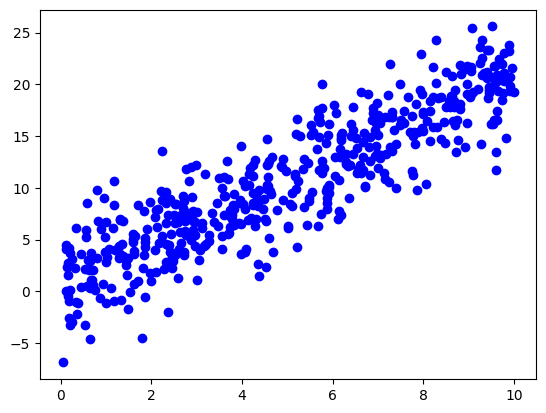

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sample_size = 500
sigma_e = 3.0             # true value of parameter error sigma
random_num_generator = np.random.RandomState(0)
x = 10.0 * random_num_generator.rand(sample_size)
e = random_num_generator.normal(0, sigma_e, sample_size)
y = 1.0 + 2.0 * x +  e          # a = 1.0; b = 2.0; y = a + b*x
plt.scatter(x, y, color='blue')

# normal equation to estimate the model parameters
X = np.vstack((np.ones(sample_size), x)).T
params_closed_form = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print('pamameters: %.7f, %.7f' %(params_closed_form[0], params_closed_form[1]))

intercept = 10.7923, slope = 5.9120


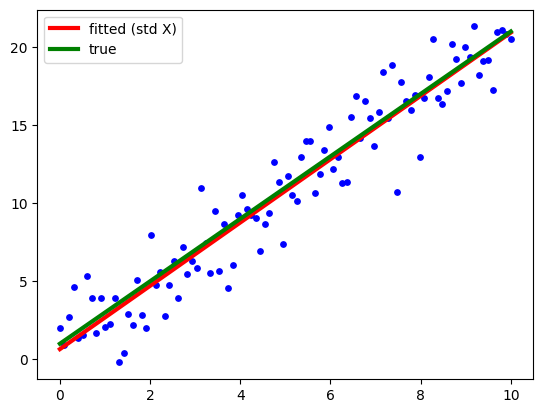

R² = 0.9147,   sqrt(R²) = 0.9564,   Pearson r = 0.9564


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# -------- sample data ----------
np.random.seed(42)
n = 100
x = np.linspace(0, 10, n)
y = 2.0 * x + 1.0 + np.random.normal(0, 2, n)

# -------- standardise X --------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x.reshape(-1, 1))

# -------- fit OLS --------------
lm = LinearRegression().fit(X_scaled, y)
print(f"intercept = {lm.intercept_:.4f}, slope = {lm.coef_[0]:.4f}")

# -------- prediction -----------
xfit = np.linspace(0, 10, n).reshape(-1, 1)
yfit = lm.predict(scaler.transform(xfit))   # now scaler definitely exists
ytrue = 2.0 * xfit.flatten() + 1.0

plt.scatter(x, y, color="blue", s=15)
plt.plot(xfit, yfit, color="red",  lw=3, label="fitted (std X)")
plt.plot(xfit, ytrue, color="green", lw=3, label="true")
plt.legend(); plt.show()

# -------- R² & corr ------------
r2   = lm.score(X_scaled, y)
corr = pearsonr(x, y)[0]
print(f"R² = {r2:.4f},   sqrt(R²) = {np.sqrt(r2):.4f},   Pearson r = {corr:.4f}")


## 2. Bayesian Linear Regression

In terms of the linear regression, Bayes's Theorem can be written as
$$
f(\beta|y,X)=\frac{f(y|\beta,X)f(\beta|X)}{f(y|X)}
$$
where $f(\beta|X)$ is the prior belief of parameter $\beta$; $f(y|\beta,X)$ is the likelihood of observing $y$ given our prior; and $f(y|X)$ is called evidence. Finally, $f(\beta|y,X)$ is the posterior belief of pararmeter $\beta$ once the evidence $y$ has been taken into account. This posterior then becomes new prior and the circle continues recursively.

### Conjugate Bayesian Simple Regression
$$
y \sim N(X\beta, \sigma_eI) \\\\
\beta \sim N(\beta_0, \Sigma_{\beta,0})
$$
produce a normally distributed posterior
$$
\beta \sim N(\beta_1, \Sigma_{\beta,1})
$$

Posterior mean after 250 updates:  intercept = 0.5488, slope = 0.5039


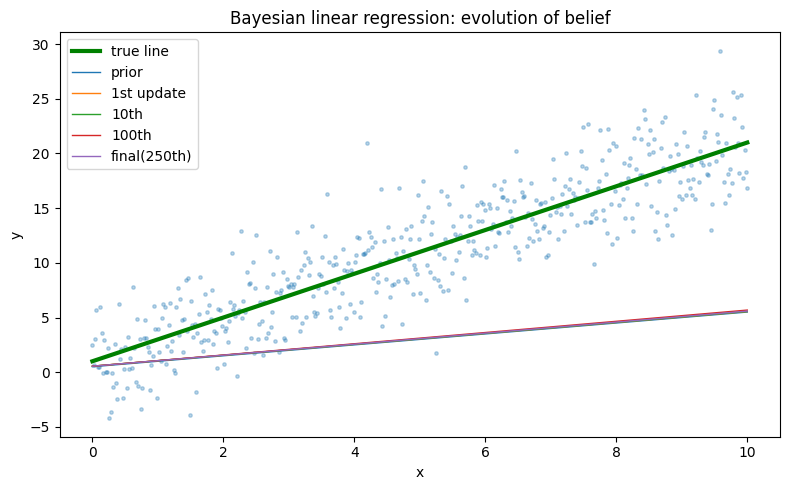

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0)  Create synthetic data: y = 2x + 1  +  N(0, σ_e²)
# ------------------------------------------------------------------
np.random.seed(42)
sample_size = 500
x = np.linspace(0, 10, sample_size)
sigma_e = 3.0                            # known observation noise
noise   = np.random.normal(0, sigma_e, sample_size)
y = 2.0 * x + 1.0 + noise                # true slope = 2, intercept = 1

# ------------------------------------------------------------------
# 1)  Prior for β = [a, b]ᵀ  ~  N(β₀, Σ₀)
# ------------------------------------------------------------------
a0, b0      = 0.5, 0.5                   # prior means
sa0, sb0    = 0.5, 0.5                   # prior std-devs  → variances = 0.25
beta_0      = np.array([[a0], [b0]])     # (2×1) column
Sigma_0     = np.diag([sa0**2, sb0**2])  # (2×2) diagonal covariance

# Keep a history of the posterior means to visualise convergence
beta_history = [beta_0.copy()]

# ------------------------------------------------------------------
# 2)  Conjugate update loop: each step consumes 2 data points
#     (see formulas in your slide: μ_y, Σ_y, Σ₁, β₁)
# ------------------------------------------------------------------
for pair in range(sample_size // 2):     # 250 iterations
    x1, x2 = x[pair*2],   x[pair*2 + 1]
    y1, y2 = y[pair*2],   y[pair*2 + 1]

    # ---- 2.1  “data in linear-coeff space”: μ_y and Σ_y -------------
    mu_y = np.array([[(x1*y2 - x2*y1) / (x1 - x2)],        # intercept from 2 points
                     [(y1 - y2)       / (x1 - x2)]])       # slope from 2 points

    Sigma_y = np.array([                                     # cov in that space
        [((x1/(x1-x2))**2 + (x2/(x1-x2))**2) * sigma_e**2, 0],
        [0, 2*(sigma_e/(x1-x2))**2]
    ])

    # ---- 2.2  Posterior covariance and mean (conjugate formulas) ----
    Sigma_1 = np.linalg.inv(np.linalg.inv(Sigma_0) + np.linalg.inv(Sigma_y))
    beta_1  = Sigma_1 @ (np.linalg.inv(Sigma_0) @ beta_0 +
                         np.linalg.inv(Sigma_y) @ mu_y)

    # ---- 2.3  Recycle: posterior → next prior -----------------------
    beta_0, Sigma_0 = beta_1, Sigma_1
    beta_history.append(beta_0.copy())

print(f"Posterior mean after 250 updates:  intercept = {beta_0[0,0]:.4f}, "
      f"slope = {beta_0[1,0]:.4f}")

# ------------------------------------------------------------------
# 3)  Visualise several stages of the learning trajectory
# ------------------------------------------------------------------
x_line  = np.linspace(0, 10, 200)
y_true  = 2.0 * x_line + 1.0            # the ground-truth line

plt.figure(figsize=(8,5))
plt.plot(x_line, y_true, color="green", lw=3, label="true line")

# draw belief curves at selected iterations
for idx, label in zip([0, 1, 10, 100, 250],
                      ["prior", "1st update", "10th", "100th", "final(250th)"]):
    a_i, b_i = beta_history[idx].flatten()
    plt.plot(x_line, b_i * x_line + a_i, lw=1, label=label)

plt.scatter(x, y, s=6, alpha=0.3)       # raw data points (optional)
plt.legend()
plt.title("Bayesian linear regression: evolution of belief")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()
